In [ ]:
import os
import mne
import pyxdf
import numpy as np
from mne.preprocessing import ICA
import matplotlib.pyplot as plt
from mne_icalabel import label_components
plt.style.use('default')
%matplotlib qt

In [ ]:
def closest_points_vector(eeg_timestamps, marker_timestamps):
    # Get the insertion indices for each marker timestamp
    indices = np.searchsorted(eeg_timestamps, marker_timestamps)

    # Preallocate the output array as a copy of indices.
    closest_eeg_indices = indices.copy()

    # Create a mask for markers where the insertion index equals 0 (marker before first EEG timestamp)
    mask_begin = (indices == 0)
    # For these, the closest EEG index is 0 (they cannot use a previous value)
    closest_eeg_indices[mask_begin] = 0

    # Create a mask for markers where the insertion index equals the length of the EEG timestamps
    mask_end = (indices == len(eeg_timestamps))
    # For these markers, set the closest EEG index to the last index
    closest_eeg_indices[mask_end] = len(eeg_timestamps) - 1

    # Create a mask for the "middle" markers, i.e., not at the very beginning or end
    mask_middle = (indices > 0) & (indices < len(eeg_timestamps))

    # For markers in the middle, compute the distance to the previous and next EEG timestamps:
    prev_times = eeg_timestamps[indices[mask_middle] - 1]
    next_times = eeg_timestamps[indices[mask_middle]]
    marker_times_middle = marker_timestamps[mask_middle]

    # Calculate the differences
    diff_prev = marker_times_middle - prev_times
    diff_next = next_times - marker_times_middle

    # For each marker in the middle, choose the index of the EEG timestamp that is closer:
    # If the distance to the previous timestamp is less or equal than the distance to the next,
    # then we pick indices[mask_middle]-1; otherwise, we pick indices[mask_middle].
    closest_eeg_indices[mask_middle] = np.where(diff_prev <= diff_next,
                                                indices[mask_middle] - 1,
                                                indices[mask_middle])

    return closest_eeg_indices

def create_mappings(event_names, prefix):
    marker_dict = {p: i for i, p in enumerate(
        np.unique(event_names))}
    id_binding = {v: k for k, v in marker_dict.items()}
    category_mapping = {
        p: {k: v for k, v in marker_dict.items() if k.startswith(p)} for p in prefix
    }
    return marker_dict, id_binding, category_mapping

def create_events(time_points, event_mapping, event_names):
    label_id_func = np.vectorize(event_mapping.get)
    events = np.zeros((len(time_points), 3), dtype=int)
    events[:, 0] = time_points
    events[:, 2] = label_id_func(event_names)
    return events

def create_mne(eeg_stream, events, id_binding, 
               flat_voltage=0.1, bandpass={'low': 1, 'high': 50}, notch_freq=60):
    ch_labels = ['L1', 'L2', 'L4', 'L5', 'L7', 'L8', 'L9', 'L10',
             'R1', 'R2', 'R4', 'R5', 'R7', 'R8', 'R9', 'R10']
    sampling_rate = float(eeg_stream['info']['nominal_srate'][0])
    if sampling_rate != 125:
        raise ValueError(f"Expected sampling rate of 125 Hz, got {sampling_rate} Hz")
    # Openbci EEG data is in microvolts, convert to volts for MNE
    eeg_data = eeg_stream['time_series'].T * 1e-6
    info = mne.create_info(
        ch_names=ch_labels, sfreq=sampling_rate, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)

    flat_voltage *= 1e-6  # Flat voltage threshold in Volts
    _, bads = mne.preprocessing.annotate_amplitude(
        raw, flat=dict(eeg=flat_voltage))
    raw.info['bads'] = bads
    print(f"Bad channels: {bads}")
    # raw.interpolate_bads()
    annot = mne.annotations_from_events(
        events, raw.info['sfreq'], id_binding)
    raw.set_annotations(annot)

    # raw.set_montage(montage)  # Set the montage to the raw object   
    # raw.plot_psd(fmax=62)

    raw = raw.notch_filter(notch_freq)
    raw = raw.filter(l_freq=bandpass['low'], h_freq=bandpass['high'])
    return raw

def read_data(sub_id, eeg_stream_name='obci_eeg1', exp_root='exp_data', bindings=None):
    DATA_FILE = os.path.join(
    exp_root, f"sub-{sub_id}", f"sub-{sub_id}_task-hearing_run-001.xdf")
    data, header = pyxdf.load_xdf(DATA_FILE)
    # print([stream['info']['type'][0] for stream in data])
    # Extract the EEG and marker streams
    marker_stream = next(
    stream for stream in data if stream['info']['type'][0] == 'Markers')
    eeg_stream = next(
    stream for stream in data
    if stream['info']['type'][0] == 'EEG' and stream['info']['name'][0] == eeg_stream_name)
    marker_timestamps = marker_stream['time_stamps']
    marker_data = np.array(marker_stream['time_series']).squeeze()
    eeg_timestamps = eeg_stream['time_stamps']
    eeg_insert_points = closest_points_vector(eeg_timestamps, marker_timestamps)
    # Create MNE events from the marker data
    if bindings is None:
        bindings = ['pmt','hlt','let','ast_stim']
    marker_dict, id_binding, category_mapping = create_mappings(marker_data, bindings)
    events = create_events(eeg_insert_points, marker_dict, marker_data)
    raw = create_mne(eeg_stream, events, id_binding)
    return raw, events, category_mapping
    # return eeg_stream, events, id_binding, category_mapping

In [ ]:
experimental = ["638390",'323706']
control = ['184632']
sub_id = control[0]  # Change this to the desired subject ID

control_raw, control_events, control_mapping = read_data(control[0], eeg_stream_name='obci_eeg1')
exp_raw, exp_events, exp_mapping = read_data(experimental[0], eeg_stream_name='obci_eeg1')

In [ ]:
exp_epoch = mne.Epochs(exp_raw, exp_events, event_id=exp_mapping['ast_stim'], tmin=-0.2, tmax=1)
control_epoch = mne.Epochs(control_raw, control_events, 
                           event_id=control_mapping['ast_stim'], tmin=-0.2, tmax=1)

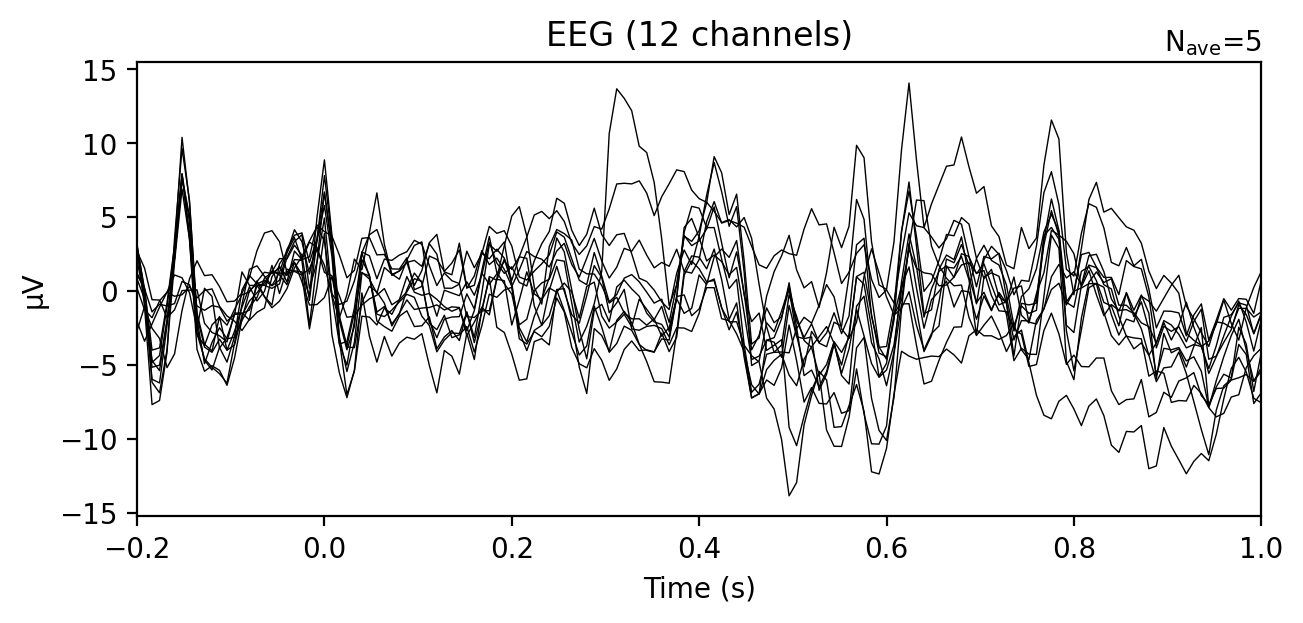

In [16]:
control_epoch['ast_stim-paper_crunching'].average().plot()

In [12]:
# e = mne.concatenate_epochs([epochs['ast_stim-paper_crunching'],
#                        epochs['ast_stim-flip'],
#                        epochs['ast_stim-control-light_rain'],
#                        epochs['ast_stim-click_continuous']])

left_ear = ['L1', 'L2', 'L4', 'L5', 'L7', 'L8', 'L9', 'L10']
right_ear = ['R1', 'R2', 'R4', 'R5', 'R7', 'R8', 'R9', 'R10']

# left_ix = mne.pick_channels(epochs.info["ch_names"], include=left_ear)
# right_ix = mne.pick_channel

In [19]:
evokeds = dict(stim=exp_epoch['ast_stim-paper_crunching'].average(), control=control_epoch['ast_stim-paper_crunching'].average())
picks = right_ear 
mne.viz.plot_compare_evokeds(evokeds, picks=picks, combine="mean")

More than 6 channels, truncating title ...
combining channels using "mean"
combining channels using "mean"


[<Figure size 1600x1200 with 1 Axes>]